# Intro

This notebook is an experimentation code for "Case study: a comparision of different consumer recommendation engines based on deep neural networks".

Paper is using [Amazon Reviews 2018 dataset](http://jmcauley.ucsd.edu/data/amazon/links.html)

Insiration notebook [can be found here](https://github.com/iritfh1/Next-item-recommendation-using-keras/blob/master/DeepRecommendation_LAST3.ipynb)


In [2]:
import pandas as pd
import os
import json
import gzip
import numpy as np
import tensorflow as tf
import tensorflow.keras as kk
import scipy.stats as st
import gc 

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [3]:
!pip install scikit-posthocs

In [4]:
import scikit_posthocs as sp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading data

In [5]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/AMAZON_FASHION_5.json.gz

--2020-07-10 06:35:44--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/AMAZON_FASHION_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287013 (280K) [application/octet-stream]
Saving to: ‘AMAZON_FASHION_5.json.gz’

AMAZON_FASHION_5.js 100%[===================>] 280.29K  --.-KB/s    in 0.1s    

2020-07-10 06:35:44 (2.41 MB/s) - ‘AMAZON_FASHION_5.json.gz’ saved [287013/287013]



In [6]:
data_f = "AMAZON_FASHION_5.json.gz"

In [7]:
data = []
with gzip.open(data_f) as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

3176
{'overall': 5.0, 'verified': True, 'reviewTime': '09 4, 2015', 'reviewerID': 'ALJ66O1Y6SLHA', 'asin': 'B000K2PJ4K', 'style': {'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}, 'reviewerName': 'Tonya B.', 'reviewText': 'Great product and price!', 'summary': 'Five Stars', 'unixReviewTime': 1441324800}


In [8]:
df = pd.DataFrame.from_dict(data)

df.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


In [9]:
df.iloc[0].style["Color:"]

' Blue/Orange'

# Preprocess data

First of all, we need to extract prouct metadata from embedded dictionary. Once all possible values are known, they will be properly encoded.

## Find unique values per each category

In [10]:
unique_values = defaultdict(lambda: set())
for i, row in df.iterrows():
    if row.style and not pd.isnull(row.style):
        for k, v in row.style.items():
            unique_values[k.replace(":", "")].add(v)

In [11]:
unique_values.keys()

dict_keys(['Size', 'Color', 'Size Name', 'Style'])

In [12]:
for k, v in unique_values.items():
    print(f"{k}: {len(v)}")

Size: 71
Color: 63
Size Name: 2
Style: 2


## Build per-category encoders

In [13]:
MISSING_VAL = 'missing'

In [14]:
style_encoders = {}
for category, values in unique_values.items():
    vals = list(values)
    vals += [MISSING_VAL]
    le = LabelEncoder()
    le.fit(vals)
    style_encoders[category] = le
    df[category] = None

In [15]:
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Size,Color,Size Name,Style
0,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN,None,None,None,None
1,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN,None,None,None,None
2,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN,None,None,None,None


## Encode values per each record

In [16]:
encoded_vals = {k: [] for k in unique_values.keys()}

for i, row in df.iterrows():
    row_styles = row.style
    if pd.isnull(row_styles):
        for cat in unique_values.keys():
            v = style_encoders[cat].transform([MISSING_VAL])[0]
            encoded_vals[cat].append(v)
    else:
        for cat in unique_values.keys():
            cat_with_colon = cat + ":"
            raw_val = row_styles[cat_with_colon] if cat_with_colon in row_styles.keys() else MISSING_VAL
            le = style_encoders[cat]
            v = le.transform([raw_val])[0]
            encoded_vals[cat].append(v)

In [17]:
for k, vals in encoded_vals.items():
    df[k] = vals

In [18]:
uencoder = LabelEncoder()
iencoder = LabelEncoder()

uencoded = uencoder.fit_transform(df.reviewerID)
iencoded  = iencoder.fit_transform(df.asin)

In [19]:
df['userid'] = uencoded
df['itemid'] = iencoded

In [20]:
df.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Size,Color,Size Name,Style,userid,itemid
0,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN,60,20,2,2,362,0
1,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN,60,7,2,2,362,0
2,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN,60,19,2,2,362,0


## Clean data

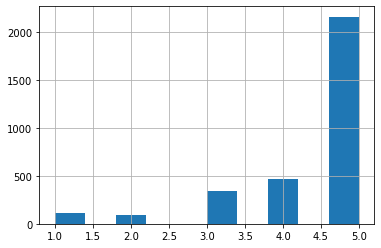

In [21]:
df.overall.hist()

# Training models

In [22]:
nusers = df.userid.nunique()
nitems = df.itemid.nunique()

nusers, nitems

(406, 31)

In [23]:
for cat, le in style_encoders.items():
    print(f"{cat}, ncls: {len(le.classes_)}")

Size, ncls: 72
Color, ncls: 64
Size Name, ncls: 3
Style, ncls: 3


In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("overall", axis=1), df.overall, random_state=123, test_size=0.15)

In [25]:
kf = KFold(n_splits=10, random_state=123)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [29]:
def MAPE(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true))

In [113]:
def train_model(model_builder, feature_builder_f, X_train, y_train, X_test, y_test, kf, *args, **kwargs):
    mse_vals = []
    mae_vals = []
    mape_vals = []
    for traini, testi in tqdm(kf.split(X_train, y_train)):
        X_train_cv, y_train_cv = X_train.iloc[traini], y_train.iloc[traini]
        X_test_cv, y_test_cv = X_train.iloc[testi], y_train.iloc[testi]

        model = model_builder()
        history = model.fit(feature_builder_f(X_train_cv), y_train_cv, epochs=10, *args, **kwargs)

        yhat_cv = model.predict(feature_builder_f(X_test_cv)).squeeze()
        mse, mae, mape = mean_squared_error(y_true=y_test_cv, y_pred=yhat_cv), mean_absolute_error(y_true=y_test_cv, y_pred=yhat_cv), MAPE(y_true=y_test_cv, y_pred=yhat_cv)
        mse_vals.append(mse)
        mae_vals.append(mae)
        mape_vals.append(mape)

    model_full = model_builder()
    full_hist = model_full.fit(feature_builder_f(X_train), y_train, *args, **kwargs)
    test_yhat = model_full.predict(feature_builder_f(X_test)).squeeze()
    test_mse, test_mae, test_mape = mean_squared_error(y_true=y_test, y_pred=test_yhat), mean_absolute_error(y_true=y_test, y_pred=test_yhat),  MAPE(y_true=y_test, y_pred=test_yhat)

    return mse_vals, mae_vals, mape_vals, test_mse, test_mae, test_mape, full_hist, model_full

In [114]:
def print_model_errors(model_name, mse, mae, mape, test_mse, test_mae, test_mape):
    print(f"""
    Model: {model_name}
    train MSE: {np.mean(mse)}
    train MAE: {np.mean(mae)}
    train MAPE: {np.mean(mape)}

    test MSE: {np.mean(test_mse)}
    test MAE: {np.mean(test_mae)}
    test MAPE: {np.mean(test_mape)}
    """)

## Collaborative filtering

In [115]:
def build_colabfilt():
    kk.backend.clear_session()
    gc.collect()

    uiembed_sz = 24

    uinput = kk.layers.Input(shape=(1,))
    uembed = kk.layers.Embedding(
        output_dim=uiembed_sz,
        input_dim=nusers+1,
        input_length=1,
        name='userembed')(uinput)
    uembed = kk.layers.Flatten()(uembed)
    ubias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nusers,
        input_length=1,
        name='ubias')(uinput))

    iinput = kk.layers.Input(shape=(1,))
    iembed = kk.layers.Embedding(
        output_dim=uiembed_sz,
        input_dim=nitems+1,
        input_length=1,
        name='iembed')(iinput)
    iembed = kk.layers.Flatten()(iembed)
    ibias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nitems+1,
        input_length=1,
        name='ibias')(iinput))

    ufull = kk.layers.add([uembed, ubias])
    ifull = kk.layers.add([iembed, ibias])
    out = kk.layers.Dot(axes=(1,1))([ifull, ufull])
    #out = kk.layers.add([dot, ubias, ibias])

    model_colab = kk.models.Model(inputs=[uinput, iinput], outputs=out)
    opt = kk.optimizers.Adam(lr=0.001)
    model_colab.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])
    return model_colab

In [116]:
colab_feature_builder = lambda data: [data.userid, data.itemid]

In [154]:
colab_mse, colab_mae, colab_mape, colab_test_mse, colab_test_mae, colab_test_mape, colab_hist, colab_model = train_model(build_colabfilt, colab_feature_builder, X_train, y_train, X_test, y_test, kf, verbose=0, validation_split=0.1)

In [156]:
print_model_errors("colab", colab_mse, colab_mae, colab_mape, colab_test_mse, colab_test_mae, colab_test_mape)


    Model: colab
    train MSE: 0.26906924027459517
    train MAE: 0.15178580229912422
    train MAPE: 0.03577652534541779

    test MSE: 20.69780258149214
    test MAE: 4.436761780251725
    test MAPE: 0.9949391631497635
    


## Deep matrix factorization

In [157]:
def build_deep_colabfilt():
    kk.backend.clear_session()
    gc.collect()

    uiembed_sz = 24

    uinput = kk.layers.Input(shape=(1,))
    uembed = kk.layers.Embedding(
        output_dim=uiembed_sz,
        input_dim=nusers+1,
        input_length=1,
        name='userembed', 
        embeddings_initializer=kk.initializers.he_normal())(uinput)
    uembed = kk.layers.Flatten()(uembed)
    ubias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nusers,
        input_length=1,
        name='ubias')(uinput))

    iinput = kk.layers.Input(shape=(1,))
    iembed = kk.layers.Embedding(
        output_dim=uiembed_sz,
        input_dim=nitems+1,
        input_length=1,
        name='iembed',
        embeddings_initializer=kk.initializers.he_normal())(iinput)
    iembed = kk.layers.Flatten()(iembed)
    ibias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nitems+1,
        input_length=1,
        name='ibias')(iinput))

    concat = kk.layers.Concatenate()([uembed, iembed, ubias, ibias])
    drop1 = kk.layers.Dropout(0.2)(concat)
    d1 = kk.layers.Dense(16, activation='tanh', kernel_regularizer=kk.regularizers.l2(0.001))(drop1)

    drop2 = kk.layers.Dropout(0.2)(d1)
    d2 = kk.layers.Dense(8, activation='tanh')(drop2)

    #drop3 = kk.layers.Dropout(0.2)(d1)
    out = kk.layers.Dense(1, activation='relu',  kernel_regularizer=kk.regularizers.l2(0.001))(d2)

    model_colab_deep = kk.models.Model(inputs=[uinput, iinput], outputs=out)
    opt = kk.optimizers.Adam(lr=0.01)
    model_colab_deep.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])
    return model_colab_deep

In [158]:
deepcolabfilt_feature_builder = lambda data: [data.userid, data.itemid]

In [159]:
deepcolab_mse, deepcolab_mae, deepcolab_mape, deepcolab_test_mse, deepcolab_test_mae, deepcolab_test_mape, deepcolab_hist, deepcolab_model = train_model(build_deep_colabfilt, deepcolabfilt_feature_builder, X_train, y_train, X_test, y_test, kf, verbose=0, validation_split=0.1)

In [160]:
# tanh activation, adam, embed: 24 - dense: (16-8-1)
print_model_errors("deep colab", deepcolab_mse, deepcolab_mae, deepcolab_mape, deepcolab_test_mse, deepcolab_test_mae, deepcolab_test_mape)


    Model: deep colab
    train MSE: 0.05921130735640009
    train MAE: 0.08726150326593904
    train MAPE: 0.03169457732461418

    test MSE: 0.5617355545271608
    test MAE: 0.5216582589616815
    test MAPE: 0.19555105594677316
    


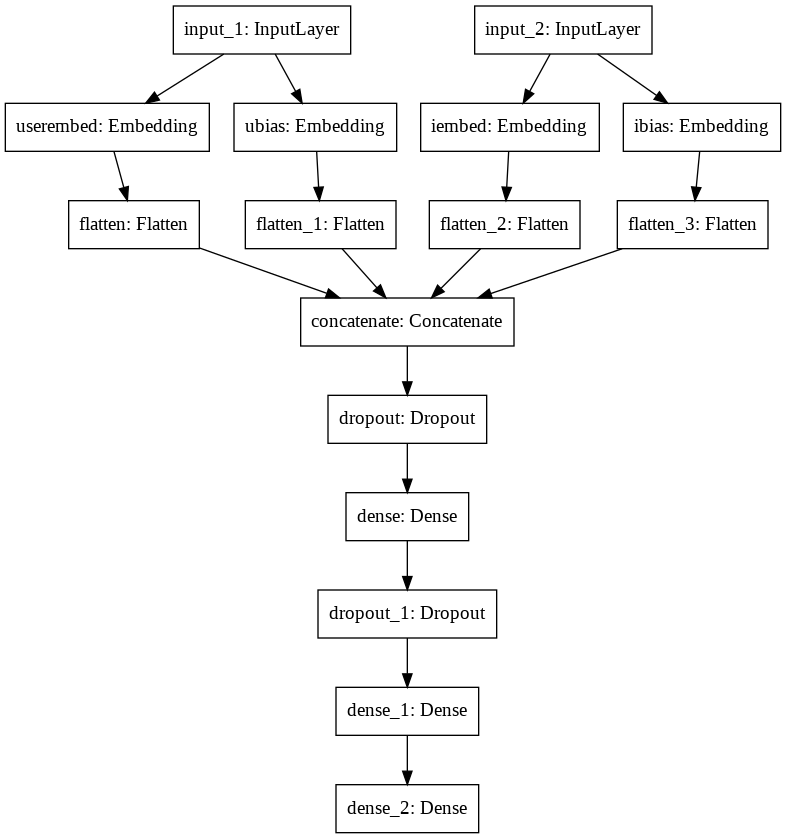

In [236]:
kk.utils.plot_model(deepcolab_model)

In [237]:
deepcolab_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
userembed (Embedding)           (None, 1, 24)        9768        input_1[0][0]                    
__________________________________________________________________________________________________
iembed (Embedding)              (None, 1, 24)        768         input_2[0][0]                    
______________________________________________________________________________________________

## Content based model

In [193]:
def build_content_model():
    kk.backend.clear_session()
    gc.collect()

    size_embed_sz = 48
    col_embed_sz = 48
    size_name_embed_sz = 3
    style_embed_sz = 3

    uiembed_sz = 32

    iinput = kk.layers.Input(shape=(1,))
    uinput = kk.layers.Input(shape=(1,))
    size_input = kk.layers.Input(shape=(1,))
    col_input = kk.layers.Input(shape=(1, ))
    size_name_input = kk.layers.Input(shape=(1,))
    style_input = kk.layers.Input(shape=(1, ))

    uembed = kk.layers.Embedding(
        output_dim=64,
        input_dim=nusers+1,
        input_length=1,
        name='userembed',
        embeddings_initializer=kk.initializers.he_normal())(uinput)
    uembed = kk.layers.Flatten()(uembed)
    ubias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nusers,
        input_length=1,
        name='ubias')(uinput))

    iembed = kk.layers.Embedding(
        output_dim=8,
        input_dim=nitems+1,
        input_length=1,
        name='iembed',
        embeddings_initializer=kk.initializers.he_normal())(iinput)
    iembed = kk.layers.Flatten()(iembed)
    ibias = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=1,
        input_dim=nitems+1,
        input_length=1,
        name='ibias')(iinput))

    user_part = kk.layers.Concatenate()([uembed, ubias])
    user_drop = kk.layers.Dropout(rate=0.2)(user_part)
    user_deep = kk.layers.Dense(32, activation='tanh', kernel_regularizer=kk.regularizers.l2(0.001))(user_drop)

    size_embed = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=size_embed_sz,
        input_dim=len(style_encoders['Size'].classes_) + 1,
        input_length=1,
        name="size_embed",
        embeddings_initializer=kk.initializers.he_normal()
    )(size_input))
    color_embed = kk.layers.Flatten()(kk.layers.Embedding(
        output_dim=col_embed_sz,
        input_dim=len(style_encoders['Color'].classes_) + 1,
        input_length=1,
        name="col_embed",
        embeddings_initializer=kk.initializers.he_normal()
    )(col_input))

    content_part = kk.layers.Concatenate()([iembed, ibias, size_embed, color_embed]) #, style_embed])
    content_drop = kk.layers.Dropout(rate=0.2)(content_part)
    conent_deep = kk.layers.Dense(16, activation='tanh', kernel_regularizer=kk.regularizers.l2(0.001))(content_drop)

    concat = kk.layers.Concatenate()([iembed, ibias, size_embed, color_embed, uembed, ubias]) #([conent_deep, user_deep])
    drop1 = kk.layers.Dropout(0.2)(concat)
    d1 = kk.layers.Dense(128, activation='tanh', kernel_regularizer=kk.regularizers.l2(0.001))(drop1)

    drop2 = kk.layers.Dropout(0.2)(d1)
    d2 = kk.layers.Dense(32, activation='tanh')(drop2)

    #drop3 = kk.layers.Dropout(0.2)(d2)
    out = kk.layers.Dense(1, activation='relu')(d2)

    model_content = kk.models.Model(inputs=[uinput, iinput, size_input, col_input, style_input], outputs=out)
    opt = kk.optimizers.Adam(0.01) #SGD(lr=0.01, momentum=0.9)
    model_content.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])
    return model_content

In [194]:
content_model_feature_builder = lambda data: [data.userid, data.itemid, data.Size, data.Color, data.Style]

In [195]:
content_mse, content_mae, content_mape, content_test_mse, content_test_mae, content_test_mape, conent_hist, content_model = train_model(build_content_model, content_model_feature_builder, X_train, y_train, X_test, y_test, kf, verbose=0)

In [196]:
print_model_errors("Content model", content_mse, content_mae, content_mape, content_test_mse, content_test_mae, content_test_mape)


    Model: Content model
    train MSE: 0.035163644121157696
    train MAE: 0.06753394948997955
    train MAPE: 0.022193513546931453

    test MSE: 0.10189070663191771
    test MAE: 0.1711329339185351
    test MAPE: 0.07531161872262646
    


In [163]:
print_model_errors("Content model", content_mse, content_mae, content_mape, content_test_mse, content_test_mae, content_test_mape)


    Model: Content model
    train MSE: 0.03487408901992961
    train MAE: 0.0792899024439764
    train MAPE: 0.023980649585737878

    test MSE: 0.13517728838223
    test MAE: 0.21587162797555984
    test MAPE: 0.07791695957163848
    


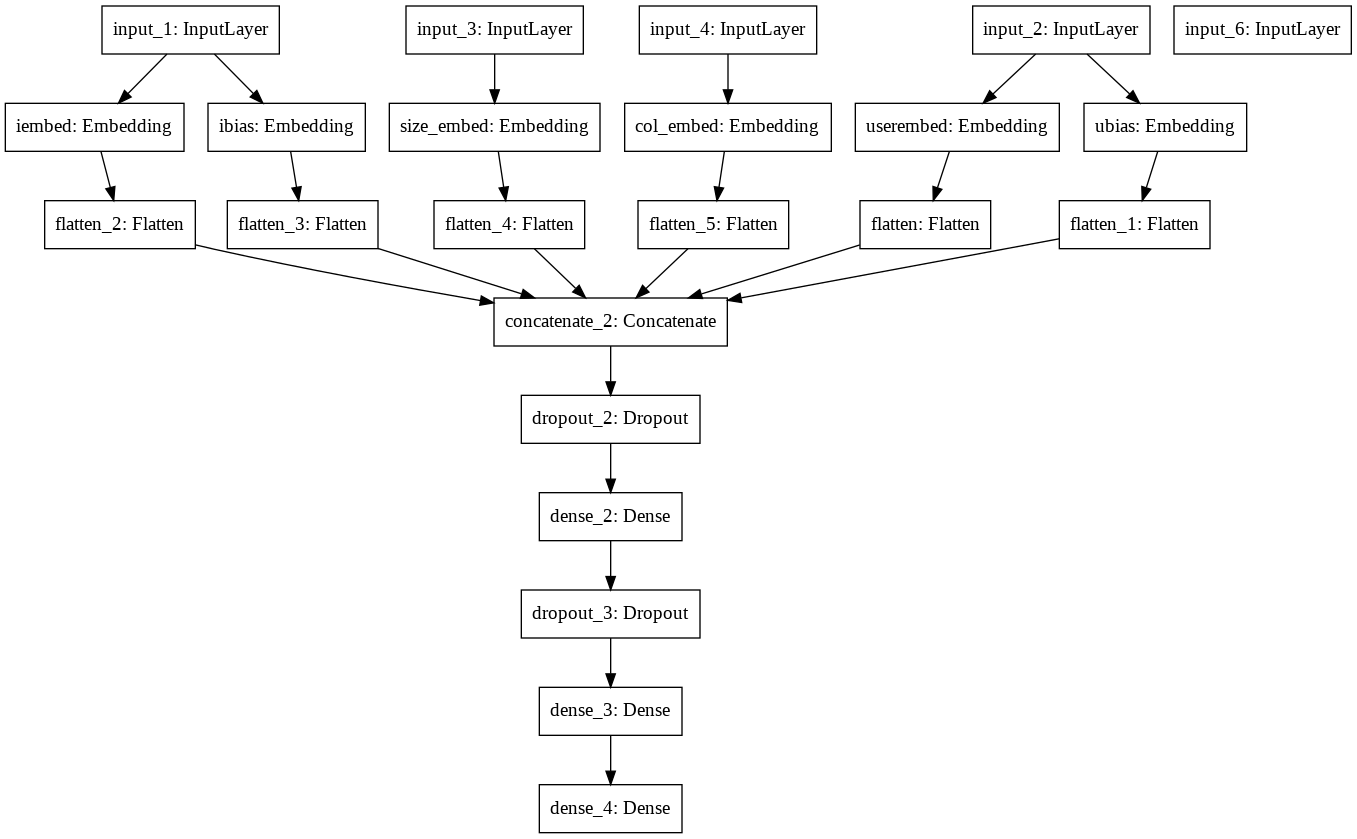

In [234]:
kk.utils.plot_model(content_model)

In [235]:
content_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

# Save model results

In [204]:
train_mae = pd.DataFrame({
    'content': content_mae,
    'deep_colab': deepcolab_mae,
    'colab': colab_mae
})
train_mse = pd.DataFrame({
    'content': content_mse,
    'deep_colab': deepcolab_mse,
    'colab': colab_mse
})
train_mape = pd.DataFrame({
    'content': content_mape,
    'deep_colab': deepcolab_mape,
    'colab': colab_mape
})

train_mae.to_csv("train_mae_res.csv", index=False)
train_mse.to_csv("train_mse_res.csv", index=False)
train_mape.to_csv("train_mape_res.csv", index=False)

test_data_res = pd.DataFrame({
    'colab': [colab_test_mae, colab_test_mape, colab_test_mse],
    'deep_colab': [deepcolab_test_mae, deepcolab_test_mape, deepcolab_test_mse],
    'content': [content_test_mae, content_test_mape, content_test_mse]
}, index=['test_mae', 'test_mape', 'test_mse'])
test_data_res.to_csv("test_data_res.csv", index=True)

In [219]:
colab_model.save("./colab_model")
content_model.save("./conent_model")
deepcolab_model.save("./deep_colab_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./colab_model/assets
INFO:tensorflow:Assets written to: ./conent_model/assets
INFO:tensorflow:Assets written to: ./deep_colab_model/assets


In [224]:
!zip -r ./colab_model.zip ./colab_model/

  adding: colab_model/ (stored 0%)
  adding: colab_model/assets/ (stored 0%)
  adding: colab_model/saved_model.pb (deflated 89%)
  adding: colab_model/variables/ (stored 0%)
  adding: colab_model/variables/variables.index (deflated 63%)
  adding: colab_model/variables/variables.data-00000-of-00001 (deflated 11%)


In [223]:
!zip -r ./content_model.zip ./conent_model/

  adding: conent_model/ (stored 0%)
  adding: conent_model/assets/ (stored 0%)
  adding: conent_model/saved_model.pb (deflated 90%)
  adding: conent_model/variables/ (stored 0%)
  adding: conent_model/variables/variables.index (deflated 68%)
  adding: conent_model/variables/variables.data-00000-of-00001 (deflated 8%)


In [222]:
!zip -r ./deep_colab_model.zip ./deep_colab_model/

  adding: deep_colab_model/ (stored 0%)
  adding: deep_colab_model/assets/ (stored 0%)
  adding: deep_colab_model/saved_model.pb (deflated 90%)
  adding: deep_colab_model/variables/ (stored 0%)
  adding: deep_colab_model/variables/variables.index (deflated 67%)
  adding: deep_colab_model/variables/variables.data-00000-of-00001 (deflated 11%)


# Statistical comparisons

In [205]:
train_mae.mean(axis=0)

content       0.067534
deep_colab    0.087262
colab         0.151786
dtype: float64

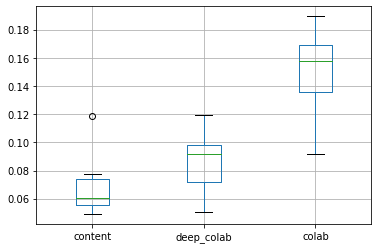

In [226]:
train_mae.boxplot()

In [206]:
train_mse.mean(axis=0)

content       0.035164
deep_colab    0.059211
colab         0.269069
dtype: float64

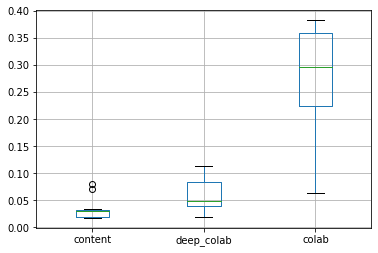

In [227]:
train_mse.boxplot()

In [207]:
train_mape.mean(axis=0)

content       0.022194
deep_colab    0.031695
colab         0.035777
dtype: float64

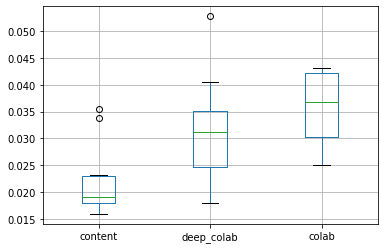

In [229]:
train_mape.boxplot()

In [208]:
print(f"""
Test MAE results:
COLAB:            {colab_test_mae}
DEEP COLAB:       {deepcolab_test_mae}
CONTENT:          {content_test_mae}
""")


Test MAE results:
COLAB:            4.436761780251725
DEEP COLAB:       0.5216582589616815
CONTENT:          0.1711329339185351



In [209]:
print(f"""
Test MSE results:
COLAB:            {colab_test_mse}
DEEP COLAB:       {deepcolab_test_mse}
CONTENT:          {content_test_mse}
""")


Test MSE results:
COLAB:            20.69780258149214
DEEP COLAB:       0.5617355545271608
CONTENT:          0.10189070663191771



In [210]:
print(f"""
Test MSE results:
COLAB:            {colab_test_mape}
DEEP COLAB:       {deepcolab_test_mape}
CONTENT:          {content_test_mape}
""")


Test MSE results:
COLAB:            0.9949391631497635
DEEP COLAB:       0.19555105594677316
CONTENT:          0.07531161872262646



In [211]:
st.mannwhitneyu(content_mse, colab_mse)

MannwhitneyuResult(statistic=2.0, pvalue=0.00016491926038899677)

In [212]:
st.mannwhitneyu(content_mse, deepcolab_mse)

MannwhitneyuResult(statistic=19.0, pvalue=0.01056696406458055)

In [213]:
st.mannwhitneyu(content_mae, colab_mae)

MannwhitneyuResult(statistic=1.0, pvalue=0.00012306406395261486)

In [214]:
st.mannwhitneyu(content_mae, deepcolab_mae)

MannwhitneyuResult(statistic=23.0, pvalue=0.022577284812139504)

In [215]:
st.mannwhitneyu(content_mape, deepcolab_mape)

MannwhitneyuResult(statistic=20.0, pvalue=0.012874040410554032)

In [216]:
sp.posthoc_mannwhitney([content_mse, deepcolab_mse, colab_mse])

,1,2,3
1,-1.000000,0.021134,0.000330
2,0.021134,-1.000000,0.000583
3,0.000330,0.000583,-1.000000


In [217]:
sp.posthoc_mannwhitney([content_mae, deepcolab_mae, colab_mae])

,1,2,3
1,-1.000000,0.045155,0.000246
2,0.045155,-1.000000,0.001008
3,0.000246,0.001008,-1.000000


In [218]:
sp.posthoc_mannwhitney([content_mape, deepcolab_mape, colab_mape])

,1,2,3
1,-1.000000,0.025748,0.002202
2,0.025748,-1.000000,0.212294
3,0.002202,0.212294,-1.000000
